In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from empyrical import max_drawdown, sharpe_ratio

In [3]:
data=pd.read_csv('daily_data.csv')

In [4]:
lookback_period = 25
multiplier = 2

data['rolling_avg_volume'] = data['volume'].rolling(window=lookback_period).mean()

data['volume_surge'] = data['volume'] > data['rolling_avg_volume'] * multiplier

In [5]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.rolling(window = smooth).mean()).rename(columns = {'macd':'signal'})
    frames =  [macd, signal]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

macd=get_macd(data.close,28,12,9)
macd

,macd,signal
0,0.000000,NaN
1,122.652520,NaN
2,232.403789,NaN
3,321.580106,NaN
4,538.490042,NaN
...,...,...
1468,-2392.123514,-1635.625641
1469,-2498.736854,-1766.223629
1470,-2586.976469,-1906.540579
1471,-2531.395089,-2037.437008


In [6]:
data['signals']=0
for i in range(len(data)):
    if(data['volume_surge'][i]==True and macd['macd'][i]>macd['signal'][i]):
        data['signals'][i]=1
    elif(data['volume_surge'][i]==True and macd['macd'][i]<macd['signal'][i]):
        data['signals'][i]=-1    

In [11]:
class TradingStrategy:

    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally
        self.trade_returns=[]
        self.portfolio_value = [] # this is the temporary portfolio value, which will store for a particular trade, then reset
        self.trade_wise_holding = [] # this represents the holding for each trade
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (temporary variable)

        self.trade_wise_final_portfolio = [] # this represents final portfolio value for each trade

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.07 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 0.35 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each trade
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        # self.transaction_percentage = 0.0015
        self.transaction_cost_per_trade = []
        self.transaction_cost_in_one_trade = 1.5

        self.risk_free_rate = 0.06 # you can change it

        self.drawdown = []
        self.dip = []
        self.trade_wise_returns = []
        self.PL_in_dollars = []

    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        trade_max_drawdown = np.min(drawdown)
        return trade_max_drawdown

    def calculate_dip(self):
        data = self.portfolio_value
        min_portfolio_value = np.min(data)
        dip = (1000 - min_portfolio_value) / 10
        return dip
    
    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.capital = 1000
        self.current_position = 1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding) # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.capital = 1000
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding)
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
    
    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.capital = 0
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
    
    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)
    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def static(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])

            if self.current_position == 0:
                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.gross_profit_per_trade = np.array(self.trade_wise_final_portfolio) - 1000
        self.trade_returns= np.array(self.trade_wise_final_portfolio)/10 - 100
        self.net_profit_per_trade = np.array(self.gross_profit_per_trade) - (self.transaction_cost_in_one_trade)

        self.profitable_trade = []
        self.loss_trade = []
        for i in range(len(self.entry)):
            if self.net_profit_per_trade[i] >= 0:
                self.profitable_trade.append(self.net_profit_per_trade[i])
            else:
                self.loss_trade.append(self.net_profit_per_trade[i])

        self.returns = np.sum(self.net_profit_per_trade) / 10

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe()

        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''


    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit
    
    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['quantity'] = self.trade_wise_holding
        trade_wise['trade type'] = self.trade_type
        trade_wise['final portfolio value'] = self.trade_wise_final_portfolio
        trade_wise['returns']=self.trade_returns
        trade_wise['drawdown'] = self.drawdown
        trade_wise['dip'] = self.dip
        return trade_wise
    
    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.profitable_trade))
        print('Losing trades:',len(self.loss_trade))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.profitable_trade)/len(self.entry))*100)
        print('Gross profit:',np.sum(self.gross_profit_per_trade))
        print('Net profit:',np.sum(self.net_profit_per_trade))
        print('Average profit:',np.mean(self.net_profit_per_trade))
        print('Maximum drawdown:',max_drawdown(self.trade_returns/100)*100)
        print('Largest win:',np.max(self.profitable_trade))
        print('Average win:',np.mean(self.profitable_trade))
        print('Largest loss:',np.min(self.loss_trade))
        print('Average loss:',np.mean(self.loss_trade))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding time:',np.mean(self.trade_wise_duration))
        print('Maximum dip:',np.max(self.dip))
        print('Average dip:',np.mean(self.dip))
        print('Returns:',self.returns ,'%')
        print('Number of times stop-loss met:',len(self.stop_loss_count))
        print('Number of time take-profit met:',len(self.take_profit_count))
        print('Sharpe ratio:', sharpe_ratio(self.trade_returns/100))

In [12]:
Testing_signals = TradingStrategy(data)
to_submit, trade_wise = Testing_signals.static()

Number of closed trade: 29
Winning trades: 21
Losing trades: 8
Benchmark returns: 2248.9531785306435
Win rate: 72.41379310344827
Gross profit: 2347.77339205094
Net profit: 2304.27339205094
Average profit: 79.45770317417035
Maximum drawdown: -8.412383826763474
Largest win: 417.83749586563954
Average win: 125.32587443862533
Largest loss: -85.62383826763471
Average loss: -40.946246395023934
Maximum holding time: 44
Average holding time: 12.241379310344827
Maximum dip: 14.554158002565464
Average dip: 3.26227693685591
Returns: 230.427339205094 %
Number of times stop-loss met: 26
Number of time take-profit met: 3
Sharpe ratio: 9.799111816850496


In [9]:
class TradingStrategy:

    '''This function initializes the class according to the data provided, it creates several variables for inside the class, as described'''
    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally

        self.portfolio_value = [] # this is the portfolio value we have at each index (each day)
        self.quantity = [] # this represents the holding at each index (each day)
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (will be updated at each index)

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.07 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent =  0.35 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each day
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        self.transaction_percentage = 0.0015

        self.risk_free_rate = 0.05 # you can change it

        self.amount_in_trade = []

        self.trade_wise_returns = []
        self.PL_in_dollars = []

        self.amount_invested_in_trade = []

    '''This is the function to calculate drawdown, it returns an array of drawdown according to portolio value,
     for maximum drawdown, we will take maximum of this drawdown array'''
    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        return drawdown

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.current_position = 1
        self.holding = self.capital / self.close[i] # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]*(1-self.transaction_percentage)
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = (self.capital - self.holding * self.close[i])*(1-self.transaction_percentage)
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
        self.portfolio_value.append(self.capital)
        self.quantity.append(0)

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.quantity.append(0)
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.quantity.append(0)
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)

    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def compounding(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])
            if self.capital < 0: # this possibility may arise in compounding approach
                print('capital wiped')

            if self.current_position == 0:

                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''
        # we now calculate the remaining parameters like trade-wise profit/loss, max drawdown, net pnl. This is purely maths as we already have our portfolio vlaue for each day stored

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.trade_wise_profit = []
        self.trade_wise_loss = []

        for i in range(len(self.entry)):
            current_trade_return = 100*((self.portfolio_value[self.exit[i]]/self.portfolio_value[self.entry[i]])-1)
            self.PL_in_dollars.append(self.portfolio_value[self.exit[i]]-self.portfolio_value[self.entry[i]])
            self.trade_wise_returns.append(current_trade_return)
            if current_trade_return >= 0:
                self.trade_wise_profit.append(current_trade_return)
            else:
                self.trade_wise_loss.append(current_trade_return)

        self.gross_profit = np.sum(self.PL_in_dollars)
        self.calculate_transaction_cost()
        self.net_profit = self.gross_profit - self.transaction_cost
        self.returns = self.net_profit / 10
        self.drawdown = self.calculate_drawdown()
        self.calculate_ratios()
        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe() , self.create_every_day_dataframe()


    def calculate_ratios(self):
        df = pd.DataFrame()
        df['portfolio_value'] = self.portfolio_value
        df['daily_return'] = df['portfolio_value'].pct_change()
        daily_volatility = df['daily_return'].std()
        annual_volatility = daily_volatility * math.sqrt(365)
        annual_volatility_negative = df[df['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
        risk_free_rate = self.risk_free_rate
        df['excess_return'] = (df['daily_return'] - risk_free_rate)
        annual_excess_return = (df['daily_return'].mean()*365 - risk_free_rate)
        cumulative_excess_return = df['excess_return'].sum()
        negative_returns = [r for r in df['excess_return'] if r < 0]
        cumulative_volatility = df['daily_return'].std()*math.sqrt(365)
        x = np.std(negative_returns)*math.sqrt(365)
        self.sharpe_ratio = annual_excess_return / annual_volatility
        self.sortino_ratio = annual_excess_return / annual_volatility_negative

        
    def calculate_transaction_cost(self):
        self.transaction_cost = 0
        for i in range(len(self.entry)):
            self.transaction_cost += self.transaction_percentage * (self.amount_invested_in_trade[i])

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['trade type'] = self.trade_type
        trade_wise['returns'] = self.trade_wise_returns
        return trade_wise

    '''This function creates and everyday log of our strategy, to analyze the portfolio value and drawdown for each day'''
    def create_every_day_dataframe(self):
        every_day = pd.DataFrame(columns=['datetime', 'portfolio value', 'quantity'])
        every_day['datetime'] = self.datetime
        every_day['quantity'] = self.quantity
        every_day['portfolio value'] = self.portfolio_value
        every_day['daily_return'] = every_day['portfolio value'].pct_change()
        every_day['drawdown'] = self.drawdown
        return every_day

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        plt.subplot(2, 1, 1)
        plt.plot(self.portfolio_value)
        plt.title('Portfolio Value')

        plt.subplot(2, 1, 2)
        plt.plot(self.drawdown, color = 'r')
        plt.title('Drawdown')

        plt.tight_layout()

        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.trade_wise_profit))
        print('Losing trades:',len(self.trade_wise_loss))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.trade_wise_profit)/len(self.entry))*100)
        print('Maximum drawdown:',max_drawdown(trade_wise['returns']/100)*100)
        print('Largest win:',np.max(self.trade_wise_profit))
        print('Average win:',np.mean(self.trade_wise_profit))
        print('Largest loss:',np.min(self.trade_wise_loss))
        print('Average loss:',np.mean(self.trade_wise_loss))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding period:',np.mean(self.trade_wise_duration))
        print('Gross Profit:',self.gross_profit)
        print('Net Profit:',self.net_profit)
        print('Returns:',self.returns,'%')
        print('Number of times stop loss met:',len(self.stop_loss_count))
        print('Number of times take profit met:',len(self.take_profit_count))
        print('Sharpe ratio:',self.sharpe_ratio)
        print('Sortino ratio:',self.sortino_ratio)

Number of closed trade: 29
Winning trades: 22
Losing trades: 7
Benchmark returns: 2248.9531785306435
Win rate: 75.86206896551724
Maximum drawdown: -8.412383826763474
Largest win: 42.146970041626396
Average win: 12.11379588900429
Largest loss: -8.27479602079466
Average loss: -4.37543205733468
Maximum holding time: 44
Average holding period: 11.758620689655173
Gross Profit: 6777.430839948111
Net Profit: 6644.032896733905
Returns: 664.4032896733904 %
Number of times stop loss met: 26
Number of times take profit met: 3
Sharpe ratio: 1.3828697515971762
Sortino ratio: 0.9568045201876133


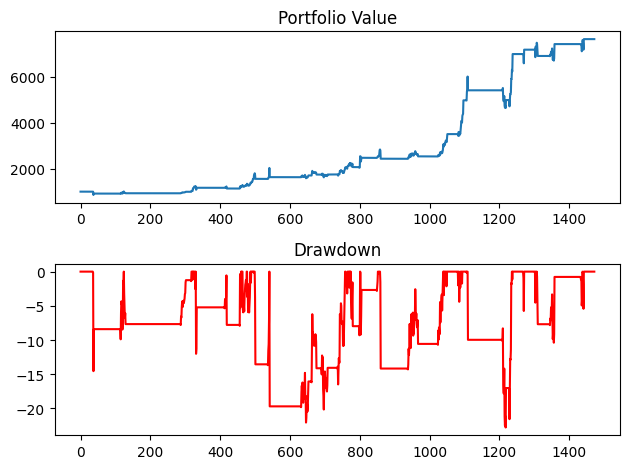

In [10]:
Testing_signals = TradingStrategy(data)
to_submit, trade_wise, every_day = Testing_signals.compounding()